In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/fight_results.csv")
df['date'] = pd.to_datetime(df['date'])

In [3]:
# shuffle the order of fighers. UFC always has the winning figher as fighter 1
df['fight_id'] = df.index
df['blue'] = np.random.choice(a=[1, 2], p=[0.5, 0.5], size=df.shape[0])
df['red'] = df['blue'].apply(lambda x: 1 if x == 2 else 2)
df['winner_colour'] = df['blue'].apply(lambda x: "blue" if x == 1 else "red")

df['str_blue'] = df.apply(lambda x: x['fighter_1_str'] if x['blue'] == 1 else x['fighter_2_str'], axis=1)
df['td_blue'] = df.apply(lambda x: x['fighter_1_td'] if x['blue'] == 1 else x['fighter_2_td'], axis=1)
df['sub_blue'] = df.apply(lambda x: x['fighter_1_sub'] if x['blue'] == 1 else x['fighter_2_sub'], axis=1)
df['pass_blue'] = df.apply(lambda x: x['fighter_1_pass'] if x['blue'] == 1 else x['fighter_2_pass'], axis=1)

df['str_red'] = df.apply(lambda x: x['fighter_1_str'] if x['red'] == 1 else x['fighter_2_str'], axis=1)
df['td_red'] = df.apply(lambda x: x['fighter_1_td'] if x['red'] == 1 else x['fighter_2_td'], axis=1)
df['sub_red'] = df.apply(lambda x: x['fighter_1_sub'] if x['red'] == 1 else x['fighter_2_sub'], axis=1)
df['pass_red'] = df.apply(lambda x: x['fighter_1_pass'] if x['red'] == 1 else x['fighter_2_pass'], axis=1)


df['blue'] = df.apply(lambda x: x['fighter_1_name'] if x['blue'] == 1 else x['fighter_2_name'], axis=1)
df['red'] = df.apply(lambda x: x['fighter_1_name'] if x['red'] == 1 else x['fighter_2_name'], axis=1)
df['blue_win'] = df['winner_colour'].apply(lambda x: 1 if x == 'blue' else 0)
df['winner'] = df.apply(lambda x: x['blue'] if x['blue_win'] == 1 else x['red'], axis=1)

df_tidy = df[['fight_id', 'event_name', 'date', 'win_method', 'winner',
              'blue', 'str_blue', 'td_blue', 'sub_blue', 'pass_blue',
              'red', 'str_red', 'td_red', 'sub_red', 'pass_red',
              'blue_win']]

df_tidy

,fight_id,event_name,date,win_method,winner,blue,str_blue,td_blue,sub_blue,pass_blue,red,str_red,td_red,sub_red,pass_red,blue_win
0,0,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"SUB, Guillotine, Choke",Charles Oliveira,Kevin Lee,41,2,0,2,Charles Oliveira,43,0,2,0,0
1,1,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"KO/TKO, Punch",Gilbert Burns,Gilbert Burns,13,0,0,0,Demian Maia,4,2,0,1,1
2,2,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"SUB, Rear, Naked, Choke",Renato Moicano,Damir Hadzovic,1,0,0,0,Renato Moicano,1,1,1,1,0
3,3,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,U-DEC,Nikita Krylov,Johnny Walker,37,0,0,2,Nikita Krylov,45,3,0,4,0
4,4,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,U-DEC,Francisco Trinaldo,Francisco Trinaldo,55,0,0,0,John Makdessi,67,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,4939,UFC_Fight_Night_6,2006-08-17,"SUB, Rear, Naked, Choke",Martin Kampmann,Crafton Wallace,1,0,0,0,Martin Kampmann,19,1,1,3,0
4940,4940,UFC_Fight_Night_6,2006-08-17,"SUB, Triangle, Choke",Joe Riggs,Joe Riggs,1,1,1,2,Jason Von Flue,0,0,0,0,1
4941,4941,UFC_Fight_Night_6,2006-08-17,"KO/TKO, Punches",Jake O'Brien,Kristof Midoux,2,0,0,0,Jake O'Brien,25,3,0,0,0
4942,4942,UFC_Fight_Night_6,2006-08-17,U-DEC,Forrest Petz,Sammy Morgan,8,0,1,0,Forrest Petz,45,6,0,3,0


## Preprocessing

In [4]:
num_cols = ['str_blue', 'td_blue', 'sub_blue', 'pass_blue', 'str_red', 'td_red', 'sub_red', 'pass_red']
X = df_tidy[num_cols + ['fight_id']]
y = df_tidy['blue_win'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1993)
train_fight_id = X_train['fight_id'].ravel()
test_fight_id = X_test['fight_id'].ravel()
X_train = X_train.drop(columns=['fight_id'])
X_test = X_test.drop(columns=['fight_id'])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models

Build and compare several different models

In [5]:
models = defaultdict(list)

def update_models(model_tracker, model, X_train, y_train, X_test, y_test, name, description):
    model_tracker['name'].append(name)
    model_tracker['description'].append(description)
    model_tracker['train_accuracy'].append(model.score(X_train, y_train))
    model_tracker['test_accuracy'].append(model.score(X_test, y_test))
    model_tracker['coef'].append(model.coef_.round(2)[0])
    model_tracker['model'].append(model)
    return model_tracker

In [6]:
lr = LogisticRegression().fit(X_train, y_train)
models = update_models(models, lr, X_train, y_train, X_test, y_test, 
                       "lr (all)", "lr with all 4 fight stats")

# print(pd.DataFrame(data=lr.coef_, columns=num_cols))

In [7]:
lr2 = LogisticRegression().fit(X_train[:,[0,4]], y_train)
models = update_models(models, lr2, X_train[:,[0,4]], y_train, X_test[:,[0,4]], y_test, 
                       "lr2 (str)", "lr only using strikes")

In [8]:
lr3 = LogisticRegression().fit(X_train[:,[1,5]], y_train)
models = update_models(models, lr3, X_train[:,[1,5]], y_train, X_test[:,[1,5]], y_test, 
                       "lr3 (td)", "lr only using takedowns")

In [9]:
lr4 = LogisticRegression().fit(X_train[:,[2,6]], y_train)
models = update_models(models, lr4, X_train[:,[2,6]], y_train, X_test[:,[2,6]], y_test, 
                       "lr4 (sub)", "lr only using subs")

In [10]:
lr5 = LogisticRegression().fit(X_train[:,[3,7]], y_train)
models = update_models(models, lr5, X_train[:,[3,7]], y_train, X_test[:,[3,7]], y_test, 
                       "lr5 (pass)", "lr only using pass")

In [11]:
pd.DataFrame(models)

,name,description,train_accuracy,test_accuracy,coef,model
0,lr (all),lr with all 4 fight stats,0.847029,0.840243,"[2.53, 0.31, 0.51, 0.5, -2.57, -0.36, -0.41, -...","LogisticRegression(C=1.0, class_weight=None, d..."
1,lr2 (str),lr only using strikes,0.797977,0.764408,"[2.45, -2.48]","LogisticRegression(C=1.0, class_weight=None, d..."
2,lr3 (td),lr only using takedowns,0.624779,0.621840,"[0.51, -0.55]","LogisticRegression(C=1.0, class_weight=None, d..."
3,lr4 (sub),lr only using subs,0.591150,0.596562,"[0.37, -0.42]","LogisticRegression(C=1.0, class_weight=None, d..."
4,lr5 (pass),lr only using pass,0.670291,0.695652,"[0.89, -0.94]","LogisticRegression(C=1.0, class_weight=None, d..."


## Model Deep Dive

Dig into models to better understand results

In [12]:
results_train = pd.DataFrame(data=X_train, columns=num_cols)
results_train['fight_id'] = train_fight_id
results_train['blue_win'] = y_train
results_train['prediction'] = lr.predict(X_train)
results_train['prediction_prob_win'] = lr.predict_proba(X_train)[:,1]
results_train['split'] = 'train'

results_test = pd.DataFrame(data=X_test, columns=num_cols)
results_test['fight_id'] = test_fight_id
results_test['blue_win'] = y_test
results_test['prediction'] = lr.predict(X_test)
results_test['prediction_prob_win'] = lr.predict_proba(X_test)[:,1]
results_test['split'] = 'test'

results = pd.concat([results_train, results_test])
results['correct'] = results.apply(lambda x: 1 if x['blue_win'] == x['prediction'] else 0, axis=1)


df_final = pd.merge(df_tidy, 
                   results[['fight_id', 'prediction', 'prediction_prob_win', 'correct', 'split']], 
                   how='left', left_on='fight_id', right_on='fight_id')

df_final['predicted_winner'] = df_final.apply(lambda x: x['blue'] if x['prediction'] == 1 else x['red'] , axis=1)

df_final

,fight_id,event_name,date,win_method,winner,blue,str_blue,td_blue,sub_blue,pass_blue,red,str_red,td_red,sub_red,pass_red,blue_win,prediction,prediction_prob_win,correct,split,predicted_winner
0,0,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"SUB, Guillotine, Choke",Charles Oliveira,Kevin Lee,41,2,0,2,Charles Oliveira,43,0,2,0,0,0,0.422122,1,train,Charles Oliveira
1,1,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"KO/TKO, Punch",Gilbert Burns,Gilbert Burns,13,0,0,0,Demian Maia,4,2,0,1,1,1,0.537584,1,train,Gilbert Burns
2,2,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,"SUB, Rear, Naked, Choke",Renato Moicano,Damir Hadzovic,1,0,0,0,Renato Moicano,1,1,1,1,0,0,0.285003,1,train,Renato Moicano
3,3,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,U-DEC,Nikita Krylov,Johnny Walker,37,0,0,2,Nikita Krylov,45,3,0,4,0,0,0.122950,1,train,Nikita Krylov
4,4,UFC_Fight_Night-Lee_vs_Oliveira,2020-03-14,U-DEC,Francisco Trinaldo,Francisco Trinaldo,55,0,0,0,John Makdessi,67,0,0,0,1,0,0.263144,0,train,John Makdessi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,4939,UFC_Fight_Night_6,2006-08-17,"SUB, Rear, Naked, Choke",Martin Kampmann,Crafton Wallace,1,0,0,0,Martin Kampmann,19,1,1,3,0,0,0.044454,1,test,Martin Kampmann
4940,4940,UFC_Fight_Night_6,2006-08-17,"SUB, Triangle, Choke",Joe Riggs,Joe Riggs,1,1,1,2,Jason Von Flue,0,0,0,0,1,1,0.806799,1,train,Joe Riggs
4941,4941,UFC_Fight_Night_6,2006-08-17,"KO/TKO, Punches",Jake O'Brien,Kristof Midoux,2,0,0,0,Jake O'Brien,25,3,0,0,0,0,0.071855,1,train,Jake O'Brien
4942,4942,UFC_Fight_Night_6,2006-08-17,U-DEC,Forrest Petz,Sammy Morgan,8,0,1,0,Forrest Petz,45,6,0,3,0,0,0.008757,1,test,Forrest Petz


In [13]:
print(df_final['correct'].sum())
print(df_final['correct'].sum()/df_final.shape[0])

4181
0.8456715210355987


For predictions that were not correct, the probability should be centered around 0.5, since the regression is not very certain.

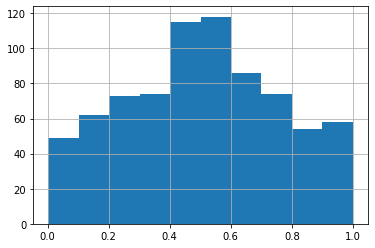

In [14]:
df_final.query('correct == 0')['prediction_prob_win'].hist();

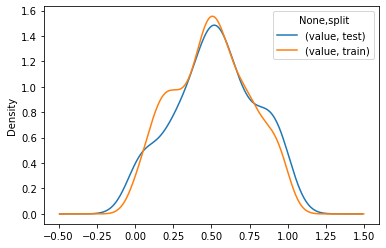

In [15]:
(df_final
 .query('correct == 0')
 .melt(id_vars='split', value_vars='prediction_prob_win')
 .drop(columns='variable')
 .pivot(columns='split')
 .plot.kde()
);

For predictions that were correct, the histogram should be u shaped, since it should be confident in predictions that were correct.

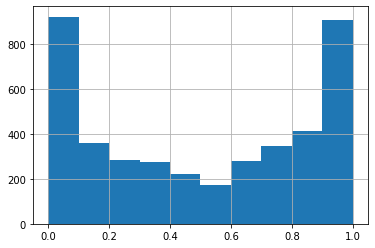

In [16]:
df_final.query('correct == 1')['prediction_prob_win'].hist();

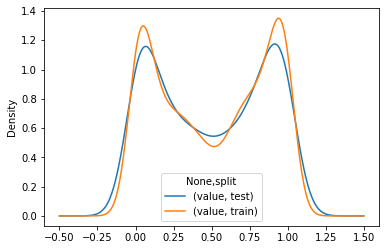

In [17]:
(df_final
 .query('correct == 1')
 .melt(id_vars='split', value_vars='prediction_prob_win')
 .drop(columns='variable')
 .pivot(columns='split')
 .plot.kde()
);

What were some incorrect predictions that were very confident?

In [18]:
(df_final
 .query('correct == 0 and prediction_prob_win > 0.9')
 .sort_values(by='prediction_prob_win', ascending=False)
 .head()
)

,fight_id,event_name,date,win_method,winner,blue,str_blue,td_blue,sub_blue,pass_blue,red,str_red,td_red,sub_red,pass_red,blue_win,prediction,prediction_prob_win,correct,split,predicted_winner
738,738,UFC_229-Khabib_vs_McGregor,2018-10-06,"KO/TKO, Punches",Derrick Lewis,Alexander Volkov,121,1,0,3,Derrick Lewis,39,0,0,0,0,1,0.999665,0,train,Alexander Volkov
3690,3690,UFC_143-Diaz_vs_Condit,2012-02-04,S-DEC,Edwin Figueroa,Alex Caceres,55,1,7,8,Edwin Figueroa,41,0,0,0,0,1,0.999368,0,train,Alex Caceres
2023,2023,UFC_195-Lawler_vs_Condit,2016-01-02,S-DEC,Robbie Lawler,Carlos Condit,176,0,0,0,Robbie Lawler,92,0,0,0,0,1,0.999239,0,train,Carlos Condit
4120,4120,UFC_117-Silva_vs_Sonnen,2010-08-07,"SUB, Triangle, Choke",Anderson Silva,Chael Sonnen,89,3,1,6,Anderson Silva,29,1,3,1,0,1,0.996791,0,train,Chael Sonnen
280,280,UFC_241-Cormier_vs_Miocic_2,2019-08-17,"KO/TKO, Punches",Stipe Miocic,Daniel Cormier,181,1,0,2,Stipe Miocic,123,1,0,0,0,1,0.995291,0,train,Daniel Cormier


In [19]:
(df_final
 .query('correct == 0 and prediction_prob_win < 0.1')
 .sort_values(by='prediction_prob_win', ascending=True)
 .head()
)

,fight_id,event_name,date,win_method,winner,blue,str_blue,td_blue,sub_blue,pass_blue,red,str_red,td_red,sub_red,pass_red,blue_win,prediction,prediction_prob_win,correct,split,predicted_winner
1399,1399,UFC_Fight_Night-Gustafsson_vs_Teixeira,2017-05-28,"KO/TKO, Knee",Damir Hadzovic,Damir Hadzovic,14,0,0,0,Marcin Held,31,4,1,11,1,0,0.002611,0,test,Marcin Held
1481,1481,UFC_209-Woodley_vs_Thompson_2,2017-03-04,"SUB, Kneebar",Iuri Alcantara,Iuri Alcantara,23,1,1,0,Luke Sanders,94,1,0,0,1,0,0.003692,0,train,Luke Sanders
4016,4016,UFC_125-Resolution,2011-01-01,Overturned,Brandon Vera,Brandon Vera,19,0,0,0,Thiago Silva,51,3,1,5,1,0,0.004846,0,train,Thiago Silva
3260,3260,UFC_159-Jones_vs_Sonnen,2013-04-27,Overturned,Jim Miller,Jim Miller,27,1,0,0,Pat Healy,53,5,2,4,1,0,0.005024,0,train,Pat Healy
629,629,UFC_Fight_Night-Lee_vs_Iaquinta,2018-12-15,U-DEC,Drakkar Klose,Drakkar Klose,58,0,0,0,Bobby Green,92,1,1,5,1,0,0.005900,0,train,Bobby Green


It looks like for a lot of the cases, it was due to a knockout which makes sense. How accurate is the model for decisions?

In [20]:
n_dec = df_final['win_method'].str.contains("DEC").sum()
print(n_dec)
df_final[df_final['win_method'].str.contains("DEC")]['correct'].sum()/n_dec

2346


0.8329070758738278

Surprisingly, the model does not do better on decisions.

In [21]:
n_tko = df_final['win_method'].str.contains("TKO").sum()
print(n_tko)
df_final[df_final['win_method'].str.contains("TKO")]['correct'].sum()/n_tko

1579


0.8562381253958201

In [22]:
n_sub = df_final['win_method'].str.contains("SUB").sum()
print(n_sub)
df_final[df_final['win_method'].str.contains("SUB")]['correct'].sum()/n_sub

957


0.8840125391849529